In [2]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
car_dataset = datasets.ImageFolder(r"E:\Text2CarsGeneration\Text2CarsGeneration\CarDatasetSimple",
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
                                   ]))

In [5]:
length = len(car_dataset)
train_length  = int(length*0.8)
validation_length = length - train_length

In [6]:
training_data, validation_data = random_split(car_dataset, [train_length, validation_length])

In [7]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [8]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [9]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [10]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [11]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=3,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

In [12]:
batch_size = 8
num_training_updates = 5000


num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [13]:
training_loader = DataLoader(training_data,
                             batch_size=1,
                             shuffle=True,
                             pin_memory=True)

In [14]:
validation_loader = DataLoader(validation_data,
                               batch_size=1,
                               shuffle=True,
                               pin_memory=True)

In [15]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [15]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

In [16]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [17]:
torch.cuda.empty_cache()

In [18]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in range(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()


    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data)
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())


    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 0.089
perplexity: 1.000

200 iterations
recon_error: 0.089
perplexity: 1.000

300 iterations
recon_error: 0.089
perplexity: 1.000

400 iterations
recon_error: 0.088
perplexity: 1.000

500 iterations
recon_error: 0.091
perplexity: 1.000

600 iterations
recon_error: 0.089
perplexity: 1.000

700 iterations
recon_error: 0.116
perplexity: 1.427

800 iterations
recon_error: 0.029
perplexity: 2.986

900 iterations
recon_error: 0.017
perplexity: 4.209

1000 iterations
recon_error: 0.014
perplexity: 6.102

1100 iterations
recon_error: 0.013
perplexity: 6.720

1200 iterations
recon_error: 0.013
perplexity: 6.785

1300 iterations
recon_error: 0.012
perplexity: 6.783

1400 iterations
recon_error: 0.012
perplexity: 6.742

1500 iterations
recon_error: 0.012
perplexity: 6.886

1600 iterations
recon_error: 0.012
perplexity: 8.608

1700 iterations
recon_error: 0.011
perplexity: 10.795

1800 iterations
recon_error: 0.012
perplexity: 11.681

1900 iterations
recon_error: 0.011


In [22]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

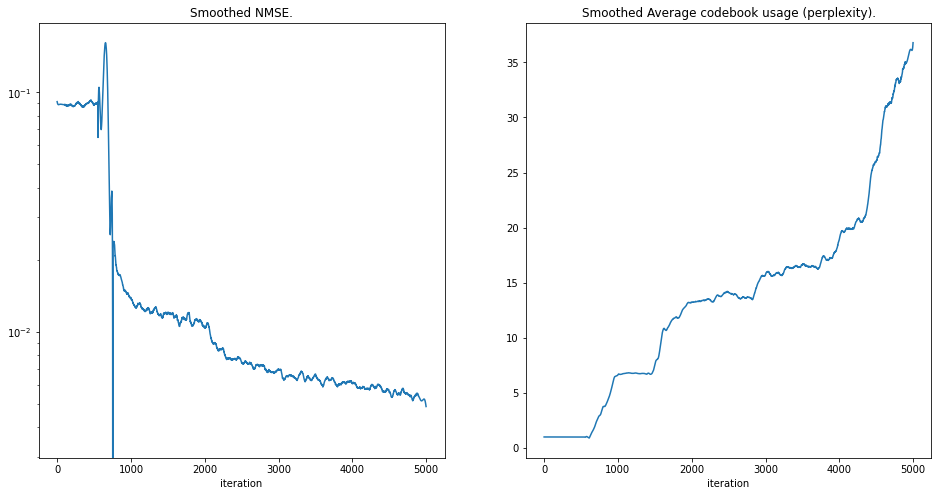

In [23]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [30]:
model.eval()
torch.save(model, "vqvae.pt")

In [17]:
torch.cuda.empty_cache()

In [16]:
model = torch.load("vqvae.pt")
model.eval()

Model(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )


In [17]:
model.eval()

(valid_originals, label) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)
t = transforms.RandomRotation((89,90))
valid_originals = t(valid_originals)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [18]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
vq_output_eval = model._pre_vq_conv(model._encoder(train_originals))
_, train_quantize, _, _ = model._vq_vae(vq_output_eval)
train_reconstructions = model._decoder(train_quantize)

In [19]:
def show(img):
    npimg = img.numpy()
    print(img.shape)
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


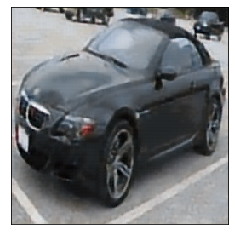

In [168]:
show(make_grid(train_reconstructions.cpu().data)+0.5, )

torch.Size([3, 256, 256])


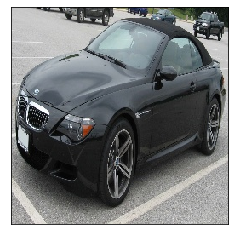

In [169]:
show(make_grid(train_originals.cpu().data)+0.5, )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


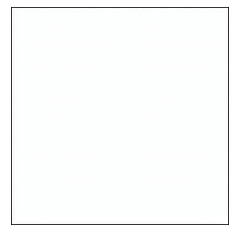

In [164]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

torch.Size([3, 256, 256])


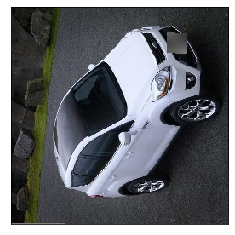

In [91]:
show(make_grid(valid_originals.cpu())+0.5, )

In [43]:
(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

In [114]:
import torchvision

In [135]:
valid_originals = torchvision.io.read_image("traktor.png").cuda()
valid_originals = valid_originals/255

In [136]:
def show(img):
    npimg = img.numpy()
    print(img.shape)
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [156]:
traktor_dataset = datasets.ImageFolder(r"E:\Text2CarsGeneration\Text2CarsGeneration\ImageGeneration\autoencoder_experiments\traktors",
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
                                   ]))

In [157]:
traktor_loader = DataLoader(traktor_dataset,
                             batch_size=1,
                             shuffle=True,
                             pin_memory=True)

In [158]:
(valid_originals, _) = next(iter(traktor_loader))

torch.Size([3, 256, 256])


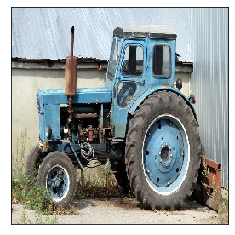

In [159]:
show(make_grid(valid_originals.cpu().data)+0.5, )

In [160]:
vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


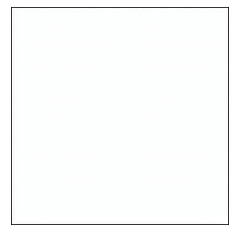

In [161]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

# Transformer training

In [ ]:
from math import log2, sqrt
import torch
from torch import nn, einsum
import torch.nn.functional as F
import numpy as np

from axial_positional_embedding import AxialPositionalEmbedding
from einops import rearrange

from dalle_pytorch import distributed_utils
from dalle_pytorch.vae import OpenAIDiscreteVAE, VQGanVAE
from dalle_pytorch.transformer import Transformer, DivideMax

# helpers

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

class always():
    def __init__(self, val):
        self.val = val
    def __call__(self, x, *args, **kwargs):
        return self.val

def is_empty(t):
    return t.nelement() == 0

def masked_mean(t, mask, dim = 1):
    t = t.masked_fill(~mask[:, :, None], 0.)
    return t.sum(dim = 1) / mask.sum(dim = 1)[..., None]

def prob_mask_like(shape, prob, device):
    return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob

def set_requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad = value

def eval_decorator(fn):
    def inner(model, *args, **kwargs):
        was_training = model.training
        model.eval()
        out = fn(model, *args, **kwargs)
        model.train(was_training)
        return out
    return inner

# sampling helpers

def log(t, eps = 1e-20):
    return torch.log(t + eps)

def gumbel_noise(t):
    noise = torch.zeros_like(t).uniform_(0, 1)
    return -log(-log(noise))

def gumbel_sample(t, temperature = 1., dim = -1):
    return ((t / temperature) + gumbel_noise(t)).argmax(dim = dim)

def top_k(logits, thres = 0.5):
    num_logits = logits.shape[-1]
    k = max(int((1 - thres) * num_logits), 1)
    val, ind = torch.topk(logits, k)
    probs = torch.full_like(logits, float('-inf'))
    probs.scatter_(1, ind, val)
    return probs

class SharedEmbedding(nn.Embedding):
    def __init__(self, linear, start_index, end_index, **kwargs):
        super().__init__(end_index - start_index, linear.weight.shape[1], **kwargs)
        del self.weight

        self.linear = linear
        self.start_index = start_index
        self.end_index = end_index

    def forward(self, input):
        return F.embedding(
            input, self.linear.weight[self.start_index:self.end_index], self.padding_idx, self.max_norm,
            self.norm_type, self.scale_grad_by_freq, self.sparse)

# discrete vae class

class ResBlock(nn.Module):
    def __init__(self, chan):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(chan, chan, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(chan, chan, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(chan, chan, 1)
        )

    def forward(self, x):
        return self.net(x) + x

class DiscreteVAE(nn.Module):
    def __init__(
        self,
        image_size = 256,
        num_tokens = 512,
        codebook_dim = 512,
        num_layers = 3,
        num_resnet_blocks = 0,
        hidden_dim = 64,
        channels = 3,
        smooth_l1_loss = False,
        temperature = 0.9,
        straight_through = False,
        kl_div_loss_weight = 0.,
        normalization = ((*((0.5,) * 3), 0), (*((0.5,) * 3), 1))
    ):
        super().__init__()
        assert log2(image_size).is_integer(), 'image size must be a power of 2'
        assert num_layers >= 1, 'number of layers must be greater than or equal to 1'
        has_resblocks = num_resnet_blocks > 0

        self.channels = channels
        self.image_size = image_size
        self.num_tokens = num_tokens
        self.num_layers = num_layers
        self.temperature = temperature
        self.straight_through = straight_through
        self.codebook = nn.Embedding(num_tokens, codebook_dim)

        hdim = hidden_dim

        enc_chans = [hidden_dim] * num_layers
        dec_chans = list(reversed(enc_chans))

        enc_chans = [channels, *enc_chans]

        dec_init_chan = codebook_dim if not has_resblocks else dec_chans[0]
        dec_chans = [dec_init_chan, *dec_chans]

        enc_chans_io, dec_chans_io = map(lambda t: list(zip(t[:-1], t[1:])), (enc_chans, dec_chans))

        enc_layers = []
        dec_layers = []

        for (enc_in, enc_out), (dec_in, dec_out) in zip(enc_chans_io, dec_chans_io):
            enc_layers.append(nn.Sequential(nn.Conv2d(enc_in, enc_out, 4, stride = 2, padding = 1), nn.ReLU()))
            dec_layers.append(nn.Sequential(nn.ConvTranspose2d(dec_in, dec_out, 4, stride = 2, padding = 1), nn.ReLU()))

        for _ in range(num_resnet_blocks):
            dec_layers.insert(0, ResBlock(dec_chans[1]))
            enc_layers.append(ResBlock(enc_chans[-1]))

        if num_resnet_blocks > 0:
            dec_layers.insert(0, nn.Conv2d(codebook_dim, dec_chans[1], 1))

        enc_layers.append(nn.Conv2d(enc_chans[-1], num_tokens, 1))
        dec_layers.append(nn.Conv2d(dec_chans[-1], channels, 1))

        self.encoder = nn.Sequential(*enc_layers)
        self.decoder = nn.Sequential(*dec_layers)

        self.loss_fn = F.smooth_l1_loss if smooth_l1_loss else F.mse_loss
        self.kl_div_loss_weight = kl_div_loss_weight

        # take care of normalization within class
        self.normalization = tuple(map(lambda t: t[:channels], normalization))

        self._register_external_parameters()

    def _register_external_parameters(self):
        """Register external parameters for DeepSpeed partitioning."""
        if (
                not distributed_utils.is_distributed
                or not distributed_utils.using_backend(
                    distributed_utils.DeepSpeedBackend)
        ):
            return

        deepspeed = distributed_utils.backend.backend_module
        deepspeed.zero.register_external_parameter(self, self.codebook.weight)

    def norm(self, images):
        if not exists(self.normalization):
            return images

        means, stds = map(lambda t: torch.as_tensor(t).to(images), self.normalization)
        means, stds = map(lambda t: rearrange(t, 'c -> () c () ()'), (means, stds))
        images = images.clone()
        images.sub_(means).div_(stds)
        return images

    @torch.no_grad()
    @eval_decorator
    def get_codebook_indices(self, images):
        logits = self(images, return_logits = True)
        codebook_indices = logits.argmax(dim = 1).flatten(1)
        return codebook_indices

    def decode(
        self,
        img_seq
    ):
        image_embeds = self.codebook(img_seq)
        b, n, d = image_embeds.shape
        h = w = int(sqrt(n))

        image_embeds = rearrange(image_embeds, 'b (h w) d -> b d h w', h = h, w = w)
        images = self.decoder(image_embeds)
        return images

    def forward(
        self,
        img,
        return_loss = False,
        return_recons = False,
        return_logits = False,
        temp = None
    ):
        device, num_tokens, image_size, kl_div_loss_weight = img.device, self.num_tokens, self.image_size, self.kl_div_loss_weight
        assert img.shape[-1] == image_size and img.shape[-2] == image_size, f'input must have the correct image size {image_size}'

        img = self.norm(img)

        logits = self.encoder(img)

        if return_logits:
            return logits # return logits for getting hard image indices for DALL-E training

        temp = default(temp, self.temperature)
        soft_one_hot = F.gumbel_softmax(logits, tau = temp, dim = 1, hard = self.straight_through)
        sampled = einsum('b n h w, n d -> b d h w', soft_one_hot, self.codebook.weight)
        out = self.decoder(sampled)

        if not return_loss:
            return out

        # reconstruction loss

        recon_loss = self.loss_fn(img, out)

        # kl divergence

        logits = rearrange(logits, 'b n h w -> b (h w) n')
        log_qy = F.log_softmax(logits, dim = -1)
        log_uniform = torch.log(torch.tensor([1. / num_tokens], device = device))
        kl_div = F.kl_div(log_uniform, log_qy, None, None, 'batchmean', log_target = True)

        loss = recon_loss + (kl_div * kl_div_loss_weight)

        if not return_recons:
            return loss

        return loss, out

# main classes

class CLIP(nn.Module):
    def __init__(
        self,
        *,
        dim_text = 512,
        dim_image = 512,
        dim_latent = 512,
        num_text_tokens = 10000,
        text_enc_depth = 6,
        text_seq_len = 256,
        text_heads = 8,
        num_visual_tokens = 512,
        visual_enc_depth = 6,
        visual_heads = 8,
        visual_image_size = 256,
        visual_patch_size = 32,
        channels = 3
    ):
        super().__init__()
        self.text_emb = nn.Embedding(num_text_tokens, dim_text)
        self.text_pos_emb = nn.Embedding(text_seq_len, dim_text)
        self.text_transformer = Transformer(causal = False, seq_len = text_seq_len, dim = dim_text, depth = text_enc_depth, heads = text_heads, rotary_emb = False)
        self.to_text_latent = nn.Linear(dim_text, dim_latent, bias = False)

        assert visual_image_size % visual_patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (visual_image_size // visual_patch_size) ** 2
        patch_dim = channels * visual_patch_size ** 2

        self.visual_patch_size = visual_patch_size
        self.to_visual_embedding = nn.Linear(patch_dim, dim_image)
        self.visual_pos_emb = nn.Embedding(num_patches, dim_image)
        self.visual_transformer = Transformer(causal = False, seq_len = num_patches, dim = dim_image, depth = visual_enc_depth, heads = visual_heads, rotary_emb = False)
        self.to_visual_latent = nn.Linear(dim_image, dim_latent, bias = False)

        self.temperature = nn.Parameter(torch.tensor(1.))

    def forward(
        self,
        text,
        image,
        text_mask = None,
        return_loss = False
    ):
        b, device, p = text.shape[0], text.device, self.visual_patch_size

        text_emb = self.text_emb(text)
        text_emb += self.text_pos_emb(torch.arange(text.shape[1], device = device))

        image_patches = rearrange(image, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        image_emb = self.to_visual_embedding(image_patches)
        image_emb += self.visual_pos_emb(torch.arange(image_emb.shape[1], device = device))

        enc_text = self.text_transformer(text_emb, mask = text_mask)
        enc_image = self.visual_transformer(image_emb)

        if exists(text_mask):
            text_latents = masked_mean(enc_text, text_mask, dim = 1)
        else:
            text_latents = enc_text.mean(dim = 1)

        image_latents = enc_image.mean(dim = 1)

        text_latents = self.to_text_latent(text_latents)
        image_latents = self.to_visual_latent(image_latents)

        text_latents, image_latents = map(lambda t: F.normalize(t, p = 2, dim = -1), (text_latents, image_latents))

        temp = self.temperature.exp()

        if not return_loss:
            sim = einsum('n d, n d -> n', text_latents, image_latents) * temp
            return sim

        sim = einsum('i d, j d -> i j', text_latents, image_latents) * temp
        labels = torch.arange(b, device = device)
        loss = (F.cross_entropy(sim, labels) + F.cross_entropy(sim.t(), labels)) / 2
        return loss

# main DALL-E class

class DALLE(nn.Module):
    def __init__(
        self,
        *,
        dim,
        vae,
        num_text_tokens = 10000,
        text_seq_len = 256,
        depth,
        heads = 8,
        dim_head = 64,
        reversible = False,
        attn_dropout = 0.,
        ff_dropout = 0,
        sparse_attn = False,
        attn_types = None,
        loss_img_weight = 7,
        stable = False,
        sandwich_norm = False,
        shift_tokens = True,
        rotary_emb = True,
        shared_attn_ids = None,
        shared_ff_ids = None,
        share_input_output_emb = False,
        optimize_for_inference = False,
    ):
        super().__init__()
        assert isinstance(vae, (Model)), 'vae must be an instance of DiscreteVAE'

        image_size = 256
        num_image_tokens = vae.num_tokens
        image_fmap_size = (image_size // (2 ** 128))
        image_seq_len = image_fmap_size ** 2

        num_text_tokens = num_text_tokens + text_seq_len  # reserve unique padding tokens for each position (text seq len)

        self.text_pos_emb = nn.Embedding(text_seq_len + 1, dim) if not rotary_emb else always(0) # +1 for <bos>
        self.image_pos_emb = AxialPositionalEmbedding(dim, axial_shape = (image_fmap_size, image_fmap_size)) if not rotary_emb else always(0)

        self.num_text_tokens = num_text_tokens # for offsetting logits index and calculating cross entropy loss
        self.num_image_tokens = num_image_tokens

        self.text_seq_len = text_seq_len
        self.image_seq_len = image_seq_len

        seq_len = text_seq_len + image_seq_len
        total_tokens = num_text_tokens + num_image_tokens
        self.total_tokens = total_tokens
        self.total_seq_len = seq_len

        self.vae = vae
        set_requires_grad(self.vae, False) # freeze VAE from being trained

        self.transformer = Transformer(
            dim = dim,
            causal = True,
            seq_len = seq_len,
            depth = depth,
            heads = heads,
            dim_head = dim_head,
            reversible = reversible,
            attn_dropout = attn_dropout,
            ff_dropout = ff_dropout,
            attn_types = attn_types,
            image_fmap_size = image_fmap_size,
            sparse_attn = sparse_attn,
            stable = stable,
            sandwich_norm = sandwich_norm,
            shift_tokens = shift_tokens,
            rotary_emb = rotary_emb,
            shared_attn_ids = shared_attn_ids,
            shared_ff_ids = shared_ff_ids,
            optimize_for_inference = optimize_for_inference,
        )

        self.stable = stable

        if stable:
            self.norm_by_max = DivideMax(dim = -1)

        self.to_logits = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, self.total_tokens),
        )

        if share_input_output_emb:
            self.text_emb = SharedEmbedding(self.to_logits[1], 0, num_text_tokens)
            self.image_emb = SharedEmbedding(self.to_logits[1], num_text_tokens, total_tokens)
        else:
            self.text_emb = nn.Embedding(num_text_tokens, dim)
            self.image_emb = nn.Embedding(num_image_tokens, dim)

        seq_range = torch.arange(seq_len)
        logits_range = torch.arange(total_tokens)

        seq_range = rearrange(seq_range, 'n -> () n ()')
        logits_range = rearrange(logits_range, 'd -> () () d')

        logits_mask = (
            ((seq_range >= text_seq_len) & (logits_range < num_text_tokens)) |
            ((seq_range < text_seq_len) & (logits_range >= num_text_tokens))
        )

        self.register_buffer('logits_mask', logits_mask, persistent=False)
        self.loss_img_weight = loss_img_weight


    @torch.no_grad()
    @eval_decorator
    def generate_texts(
        self,
        tokenizer,
        text = None,
        *,
        filter_thres = 0.5,
        temperature = 1.
    ):
        text_seq_len = self.text_seq_len
        if text is None or text == "":
            text_tokens = torch.tensor([[0]]).cuda()
        else:
            text_tokens = torch.tensor(tokenizer.tokenizer.encode(text)).cuda().unsqueeze(0)

        for _ in range(text_tokens.shape[1], text_seq_len):
            device = text_tokens.device

            tokens = self.text_emb(text_tokens)
            tokens += self.text_pos_emb(torch.arange(text_tokens.shape[1], device = device))

            seq_len = tokens.shape[1]

            output_transf = self.transformer(tokens)

            if self.stable:
                output_transf = self.norm_by_max(output_transf)

            logits = self.to_logits(output_transf)

            # mask logits to make sure text predicts text (except last token), and image predicts image

            logits_mask = self.logits_mask[:, :seq_len]
            max_neg_value = -torch.finfo(logits.dtype).max
            logits.masked_fill_(logits_mask, max_neg_value)
            logits = logits[:, -1, :]

            filtered_logits = top_k(logits, thres = filter_thres)
            sample = gumbel_sample(filtered_logits, temperature = temperature, dim = -1)

            text_tokens = torch.cat((text_tokens, sample[:, None]), dim=-1)

        padding_tokens = set(np.arange(self.text_seq_len) + (self.num_text_tokens - self.text_seq_len))
        texts = [tokenizer.tokenizer.decode(text_token, pad_tokens=padding_tokens) for text_token in text_tokens]
        return text_tokens, texts

    @torch.no_grad()
    @eval_decorator
    def generate_images(
        self,
        text,
        *,
        clip = None,
        filter_thres = 0.5,
        temperature = 1.,
        img = None,
        num_init_img_tokens = None,
        cond_scale = 1.,
        use_cache = False,
    ):
        vae, text_seq_len, image_seq_len, num_text_tokens = self.vae, self.text_seq_len, self.image_seq_len, self.num_text_tokens
        total_len = text_seq_len + image_seq_len

        text = text[:, :text_seq_len] # make sure text is within bounds
        out = text

        if exists(img):
            image_size = vae.image_size
            assert img.shape[1] == 3 and img.shape[2] == image_size and img.shape[3] == image_size, f'input image must have the correct image size {image_size}'

            indices = vae.get_codebook_indices(img)
            num_img_tokens = default(num_init_img_tokens, int(0.4375 * image_seq_len))  # OpenAI used 14 * 32 initial tokens to prime
            assert num_img_tokens < image_seq_len, 'number of initial image tokens for priming must be less than the total image token sequence length'

            indices = indices[:, :num_img_tokens]
            out = torch.cat((out, indices), dim = -1)

        prev_cache = None
        cache = {} if use_cache else None
        for cur_len in range(out.shape[1], total_len):
            is_image = cur_len >= text_seq_len

            text, image = out[:, :text_seq_len], out[:, text_seq_len:]

            logits = self.forward_with_cond_scale(text, image, cond_scale = cond_scale, cache = cache)
            logits = logits[:, -1, :]

            filtered_logits = top_k(logits, thres = filter_thres)
            sample = gumbel_sample(filtered_logits, temperature = temperature, dim = -1)

            sample -= (num_text_tokens if is_image else 0) # offset sampled token if it is an image token, since logit space is composed of text and then image tokens
            out = torch.cat((out, sample[:, None]), dim=-1)

        text_seq = out[:, :text_seq_len]

        img_seq = out[:, -image_seq_len:]
        images = vae.decode(img_seq)

        if exists(clip):
            scores = clip(text_seq, images, return_loss = False)
            return images, scores

        return images

    def forward_with_cond_scale(self, *args, cond_scale = 1, cache = None, **kwargs):
        if cond_scale == 1:
            return self(*args, **kwargs)

        prev_cache = cache.copy() if exists(cache) else None
        logits = self(*args, cache = cache, **kwargs)

        # discovery by Katherine Crowson
        # https://twitter.com/RiversHaveWings/status/1478093658716966912
        null_cond_logits = self(*args, null_cond_prob = 1., cache = prev_cache, **kwargs)
        return null_cond_logits + (logits - null_cond_logits) * cond_scale

    def forward(
        self,
        text,
        image = None,
        return_loss = False,
        null_cond_prob = 0.,
        cache = None,
    ):
        assert text.shape[-1] == self.text_seq_len, f'the length {text.shape[-1]} of the text tokens you passed in does not have the correct length ({self.text_seq_len})'
        batch, device, total_seq_len = text.shape[0], text.device, self.total_seq_len

        # randomly remove text condition with <null_cond_prob> probability

        if null_cond_prob > 0:
            null_mask = prob_mask_like((batch,), null_cond_prob, device = device)
            text *= rearrange(~null_mask, 'b -> b 1')

        # make sure padding in text tokens get unique padding token id

        text_range = torch.arange(self.text_seq_len, device = device) + (self.num_text_tokens - self.text_seq_len)
        text = torch.where(text == 0, text_range, text)

        # add <bos>

        text = F.pad(text, (1, 0), value = 0)

        tokens = self.text_emb(text)
        tokens += self.text_pos_emb(torch.arange(text.shape[1], device = device))

        seq_len = tokens.shape[1]

        if exists(image) and not is_empty(image):
            is_raw_image = len(image.shape) == 4

            if is_raw_image:
                image_size = self.vae.image_size
                channels = self.vae.channels
                assert tuple(image.shape[1:]) == (channels, image_size, image_size), f'invalid image of dimensions {image.shape} passed in during training'

                image = self.vae.get_codebook_indices(image)

            image_len = image.shape[1]
            image_emb = self.image_emb(image)

            image_emb += self.image_pos_emb(image_emb)

            tokens = torch.cat((tokens, image_emb), dim = 1)

            seq_len += image_len

        # when training, if the length exceeds the total text + image length
        # remove the last token, since it needs not to be trained

        if tokens.shape[1] > total_seq_len:
            seq_len -= 1
            tokens = tokens[:, :-1]

        if self.stable:
            alpha = 0.1
            tokens = tokens * alpha + tokens.detach() * (1 - alpha)

        if exists(cache) and cache.get('offset'):
            tokens = tokens[:, -1:]
        out = self.transformer(tokens, cache=cache)

        if self.stable:
            out = self.norm_by_max(out)

        logits = self.to_logits(out)

        # mask logits to make sure text predicts text (except last token), and image predicts image

        logits_mask = self.logits_mask[:, :seq_len]
        if exists(cache) and cache.get('offset'):
            logits_mask = logits_mask[:, -1:]
        max_neg_value = -torch.finfo(logits.dtype).max
        logits.masked_fill_(logits_mask, max_neg_value)

        if exists(cache):
            cache['offset'] = cache.get('offset', 0) + logits.shape[1]

        if not return_loss:
            return logits

        assert exists(image), 'when training, image must be supplied'

        offsetted_image = image + self.num_text_tokens
        labels = torch.cat((text[:, 1:], offsetted_image), dim = 1)

        logits = rearrange(logits, 'b n c -> b c n')

        loss_text = F.cross_entropy(logits[:, :, :self.text_seq_len], labels[:, :self.text_seq_len])
        loss_img = F.cross_entropy(logits[:, :, self.text_seq_len:], labels[:, self.text_seq_len:])

        loss = (loss_text + self.loss_img_weight * loss_img) / (self.loss_img_weight + 1)
        return loss


In [35]:
import argparse

from pathlib import Path
import time
from glob import glob
import os
import shutil

import torch
import wandb  # Quit early if user doesn't have wandb installed.
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

from dalle_pytorch import __version__
from dalle_pytorch import OpenAIDiscreteVAE, VQGanVAE, DiscreteVAE, DALLE
from dalle_pytorch import distributed_utils
from dalle_pytorch.loader import TextImageDataset
from dalle_pytorch.tokenizer import tokenizer, HugTokenizer, ChineseTokenizer, YttmTokenizer

# libraries needed for webdataset support

from torchvision import transforms as T
from PIL import Image
from io import BytesIO

In [36]:
def exists(val):
    return val is not None

def get_trainable_params(model):
    return [params for params in model.parameters() if params.requires_grad]

def cp_path_to_dir(cp_path, tag):
    """Convert a checkpoint path to a directory with `tag` inserted.
    If `cp_path` is already a directory, return it unchanged.
    """
    if not isinstance(cp_path, Path):
        cp_path = Path(cp_path)
    if cp_path.is_dir():
        return cp_path
    path_sans_extension = cp_path.parent / cp_path.stem
    cp_dir = Path(f'{path_sans_extension}-{tag}-cp')
    return cp_dir

In [37]:
# constants

WEBDATASET_IMAGE_TEXT_COLUMNS = tuple(''.split(','))
ENABLE_WEBDATASET = True if len(WEBDATASET_IMAGE_TEXT_COLUMNS) == 2 else False

DALLE_OUTPUT_FILE_NAME = "dalle.pt"

VAE_PATH = r"E:\Text2CarsGeneration\Text2CarsGeneration\ImageGeneration\autoencoder_experiments\vqvae.pt"
VQGAN_MODEL_PATH = None
VQGAN_CONFIG_PATH = None
DALLE_PATH = None
RESUME = exists(DALLE_PATH)

EPOCHS = 5
BATCH_SIZE = 4

LEARNING_RATE = 3e-4
GRAD_CLIP_NORM = 0.5
LR_DECAY = None
SAVE_EVERY_N_STEPS = 1000
KEEP_N_CHECKPOINTS = None

MODEL_DIM = 512
TEXT_SEQ_LEN = 256
DEPTH = 2
HEADS = 8
DIM_HEAD = 64
REVERSIBLE = None
LOSS_IMG_WEIGHT = 7
FF_DROPOUT = 0.0
ATTN_DROPOUT = 0.0
STABLE = None
SHIFT_TOKENS = None
ROTARY_EMB = None

ATTN_TYPES = tuple('full'.split(','))
SHARED_ATTN_IDS = None
SHARED_FF_IDS = None
SHARE_INPUT_OUTPUT_EMB = None

DEEPSPEED_CP_AUX_FILENAME = 'auxiliary.pt'

In [38]:
image_text_folder = "E:\Text2CarsGeneration\Text2CarsGeneration\CarDatasetSimple"

In [39]:
if not ENABLE_WEBDATASET:
    # quit early if you used the wrong folder name
    assert Path(image_text_folder).exists(), f'The path {image_text_folder} was not found.'

In [42]:
vae_path = Path(VAE_PATH)
assert vae_path.exists(), 'VAE model file does not exist'
assert not vae_path.is_dir(), \
    ('Cannot load VAE model from directory; please use a '
     'standard *.pt checkpoint. '
     'Currently, merging a DeepSpeed-partitioned VAE into a DALLE '
     'model is not supported.')

vae = torch.load(str(vae_path))

In [44]:
dalle_params = dict(
        num_text_tokens=tokenizer.vocab_size,
        text_seq_len=TEXT_SEQ_LEN,
        dim=MODEL_DIM,
        depth=DEPTH,
        heads=HEADS,
        dim_head=DIM_HEAD,
        reversible=REVERSIBLE,
        loss_img_weight=LOSS_IMG_WEIGHT,
        attn_types=ATTN_TYPES,
        ff_dropout=FF_DROPOUT,
        attn_dropout=ATTN_DROPOUT,
        stable=STABLE,
        shift_tokens=SHIFT_TOKENS,
        rotary_emb=ROTARY_EMB,
        shared_attn_ids=SHARED_ATTN_IDS,
        shared_ff_ids=SHARED_FF_IDS,
        share_input_output_emb=SHARE_INPUT_OUTPUT_EMB,
    )
resume_epoch = 0

In [45]:
dalle = DALLE(vae=vae, **dalle_params)

# optimizer
opt = Adam(get_trainable_params(dalle), lr=LEARNING_RATE)

AssertionError: vae must be an instance of DiscreteVAE